# Convolutional Neural Networks - Age Prediction

## Preparations

In [1]:
import os

## adapt this directories to your needs
base_dir = '../../'
data_dir_base = "D:/Users/Julian/OneDrive - FH OOe/Kurse/3. Semester/NDLeIL/Datasets"
notebook_dir = os.path.join(base_dir, 'Exercise')
data_dir = os.path.join(data_dir_base, 'age-prediction/20-50')

In [2]:
import os, shutil
import random
import sys

import numpy as np
import pandas as pd
import tensorflow as tf

from pyMLaux import show_img_data, plot_history, evaluate_regression_result

In [3]:
train_data_dir = os.path.join(data_dir, 'train')
test_data_dir = os.path.join(data_dir, 'test')

## Configure Data Sources

In [4]:
batch_size = 64
img_size = (128, 128)

In [5]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    shuffle=True,
    validation_split=0.15,
    subset='training',
    seed = 4232,
    image_size=img_size,
    batch_size=batch_size)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    shuffle=True,
    validation_split=0.15,
    subset='validation',
    seed=4232,
    image_size=img_size,
    batch_size=batch_size)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    shuffle=False,
    image_size=img_size,
    batch_size=batch_size)

Found 33432 files belonging to 31 classes.
Using 28418 files for training.
Found 33432 files belonging to 31 classes.
Using 5014 files for validation.
Found 7008 files belonging to 31 classes.


In [6]:
train_data.class_names

['20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50']

In [ ]:
for image_batch, label_batch in train_data:
    show_img_data(image_batch / 255., no=batch_size, layout=(8, 8), figsize=(6, 6))
    break

## Create Model
### Modified compared to model 2:
* Added intermediate conv block with 48 filters to increase model capacity and have a more gradual reduction of spatial dimensions
* Added learning rate plateau reduction (factor=0.3, patience=2)
* Adam solver with default Initial learning rate set to 1e-4

In [ ]:
# Pre-processing as required by ResNet50
preprocess = tf.keras.applications.resnet50.preprocess_input

data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.02, fill_mode='constant', fill_value=0.),
    tf.keras.layers.RandomZoom(0.1, fill_mode='constant', fill_value=0.)
], name='data_augmentation')

# Base model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

# Freeze early layers
base_model.trainable = False
for layer in base_model.layers[-15:]:  # Unfreeze last 15 layers
    layer.trainable = True

# Full model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    preprocess,
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation=None, use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='linear')
])

# Training setup
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.3,
    patience=2,
    min_lr=1e-6
)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

In [ ]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_15 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 128, 128, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_116 (Activation)     │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 128, 128, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_117 (Activation)     │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 64, 64, 48)     │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_118         │ (None, 64, 64, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_118 (Activation)     │ (None, 64, 64, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 64, 64, 48)     │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_119         │ (None, 64, 64, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_119 (Activation)     │ (None, 64, 64, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 32, 32, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 32, 32, 64)     │        27,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_120         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_120 (Activation)     │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 32, 32, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_121         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_121 (Activation)     │ (None, 32, 32, 64)     │             

 Total params: 326,273 (1.24 MB)

 Trainable params: 325,249 (1.24 MB)

 Non-trainable params: 1,024 (4.00 KB)

## Train Model

In [ ]:
filepath = os.path.join(base_dir, 'Models/age-prediction_model4/age-prediction4_{epoch:02d}-{val_mae:.4f}.keras')

# Callbacks for saving the best models
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_mae', verbose=1,
                                                save_best_only=True, mode='min')

callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_data, epochs=50, validation_data=validation_data,
                    callbacks=callbacks_list)

Epoch 1/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 296.2120 - mae: 14.7348
Epoch 1: val_mae improved from inf to 13.33041, saving model to ../../Models/age-prediction_model3/age-prediction3_01-13.3304.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 873s 2s/step - loss: 296.1909 - mae: 14.7342 - val_loss: 250.9037 - val_mae: 13.3304 - learning_rate: 1.0000e-04
Epoch 2/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 260.0326 - mae: 13.6236
Epoch 2: val_mae improved from 13.33041 to 11.77306, saving model to ../../Models/age-prediction_model3/age-prediction3_02-11.7731.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 865s 2s/step - loss: 260.0128 - mae: 13.6230 - val_loss: 202.9405 - val_mae: 11.7731 - learning_rate: 1.0000e-04
Epoch 3/50
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 230.6902 - mae: 12.6752
Epoch 3: val_mae improved from 11.77306 to 10.85469, saving model to ../../Models/age-prediction_model3/age-prediction3_03-10.8547.keras
445/445 ━━━━━━━━━━━━━━━━━━━━ 867s 2s/step - loss: 230.6753 - 

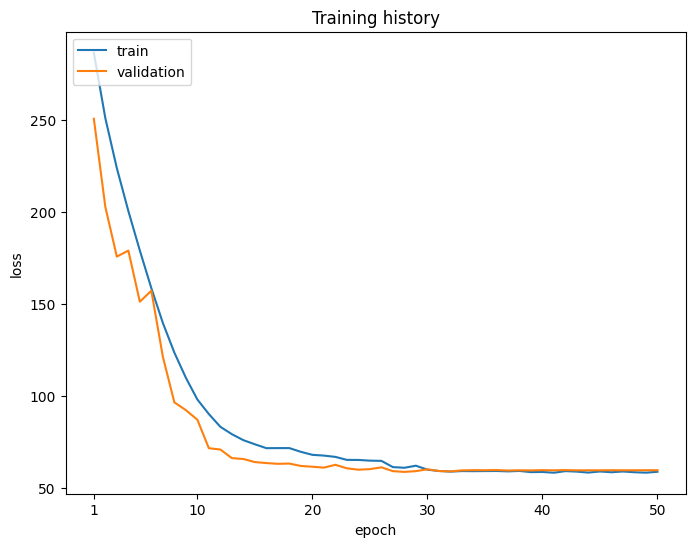

In [ ]:
plot_history(history)

## Evaluate on Test Data

In [ ]:
pred = model.predict(test_data)

110/110 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step


In [ ]:
test_y = np.concatenate([labels for _, labels in test_data], axis=0)

In [ ]:
evaluate_regression_result(test_y + 20., pred + 20.) # Add  20.0 to make sure we add the correct offset

Target feature 0:
    Mean squared error (MSE):           60.196
    Root mean squared error (RMSE):      7.759
    Mean absolute error (MAE):           6.365
    Coefficient of determination (R2):   0.257
    Correlation coefficient (Pearson):   0.519 (p = 0.00e+00)


## Evaluate on Test Data (best model)

In [ ]:
# Load the best model
model = tf.keras.models.load_model(r"../../Models\age-prediction_model4\age-prediction4_28-6.2721.keras")

In [114]:
pred = model.predict(test_data)

110/110 ━━━━━━━━━━━━━━━━━━━━ 79s 677ms/step


In [115]:
evaluate_regression_result(test_y + 20., pred + 20.) # Add  20.0 to make sure we add the correct offset 

Target feature 0:
    Mean squared error (MSE):           59.094
    Root mean squared error (RMSE):      7.687
    Mean absolute error (MAE):           6.291
    Coefficient of determination (R2):   0.270
    Correlation coefficient (Pearson):   0.523 (p = 0.00e+00)


In [117]:
!jupyter nbconvert --to html Ex4_Grimm_Model3.ipynb

[NbConvertApp] Converting notebook Ex4_Grimm_Model3.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 847094 bytes to Ex4_Grimm_Model3.html
